# Tensorflow Similarity Hello World
**Alpha version** here will be dragons


## Notebook goal
Demonstrate the core concept of few-shot learning and how to perform it using TensorFlow Similarity. To do we are going to:
 1. `train()` a similarity model on a sub-set of the 10 fashion MNIST classes that learn how to project images in a cosine space.

 2. `index()` a few examples of each of the class present in the train dataset (e.g 10 per classes).

 3. `lookup()` some the test data to showcase how our models is able to match unseen classes while having only a few examples of each in its index/

 4. `calibrate()` our model to estimate what is the best distance theshold to separate matching elments from elements belonging to different classes.

 5. `evalute()` how well our model/index perform.

 6. `match()` a few examples to test our calibration.

## Performance tips
- The more class you train on the easier it is for the model
- More training epoch  can help improve accuracy
- larger embedding can help improve accuracy
- Augmentation can help improve accuracy
- More examples for calibration gives better results

## Known major limitations
- No `save()` / `load()`
- `batch_lookup()` is broken
- `calibrate()` scores are not correctly computed

There are many other unfinished features and bugs - you have been warmed!


Send feeback to elieb@  - code: [private github (ask for access)](https://github.com/tensorflow/similarity)

In [2]:
 %load_ext autoreload
 %autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  TensorBoard
from time import  time
from tabulate import tabulate
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

In [5]:
from tensorflow_similarity.utils import tf_cap_memory
from tensorflow_similarity.losses import TripletLoss
from tensorflow_similarity.layers import MetricEmbedding
from tensorflow_similarity.model import SimilarityModel
from tensorflow_similarity.sampler import MultiShotMemorySampler
from tensorflow_similarity.sampler import select_examples
from tensorflow_similarity.visualization import viz_neigbors_imgs

In [6]:
tf_cap_memory()
print(tf.__version__)

2.3.1



s.


Note: Tensorflow similarity expect y_train to be the examples class as integer so there is no need for processing

In [21]:
NUM_CLASSES = 8  #@param {type: "slider", min: 1, max: 10}
classes = list(range(10))

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = tf.constant(x_train / 255.0, dtype='float32')
x_test = tf.constant(x_test / 255.0, dtype='float32')

x_restricted, y_restricted = select_examples(x_train, y_train, classes[:NUM_CLASSES], 10000)
print(x_restricted.shape, y_restricted.shape)

(48000, 28, 28) (48000,)


In [8]:
BATCH_SIZE = 16 #@param{Integer}
CLASS_PER_BATCH = 8
sampler = MultiShotMemorySampler(x_restricted, y_restricted, class_per_batch=CLASS_PER_BATCH, batch_size=BATCH_SIZE)

# model creation

In [9]:
def get_model():
    tf.keras.backend.clear_session()
    inputs = tf.keras.layers.Input(shape=(28,28))
    x = layers.Reshape((28,28,1))(inputs)
    x = layers.Conv2D(16, 3, activation='relu')(x)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = MetricEmbedding(32)(x)
    # outputs2 = MetricEmbedding(10)(x)
    return SimilarityModel(inputs, outputs)
model = get_model()
model.summary()

Model: "similarity_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7744)         

# Loss definition

Overall Similarity losses (aka metric losses) are similar to other losses except they expect different inputs.

For triplet loss, one of the most popular one, you need to decide what type of triplet mining you want. Usually `hard` mining for positive example and `semi-hard` mining work well and are the default. They are passed explicitly here for reference.

The `distance` parameters specify which distance metric to use to compute the distance between embeddings. `cosine` is usually a great starting point and the default.


In [23]:
distance = 'cosine' #@param ["cosine"]{allow-input: false}
positive_mining_strategy = 'hard' #@param ["easy", "hard"]{allow-input: false}
negative_mining_strategy = 'semi-hard' #@param ["easy", "hard"]{allow-input: false}
triplet_loss = TripletLoss(distance=distance,
    positive_mining_strategy=positive_mining_strategy,
    negative_mining_strategy=negative_mining_strategy)

# Compilation

Tensorflow similarity use an extended `compile()` method that allows you to specify distance_metrics (metrics that are computed over the distance between the embedding). 

By default the `compile()` method try to infers what type of distance you are using by looking at the fist loss specified. If you use multiples losses and the distance loss is not the first, then you need to specify the distance function used as `distance=` parameter in the compile function.

In [24]:
model = get_model()
model.compile(optimizer='adam', loss=triplet_loss)

# Training

Similarity are trained like normal model. Don't expect the validation loss to decrease too much because we only use half of the class on the train data but all class in the validation.

In [25]:
EPOCHS = 8 #@param{Integer}

history = model.fit(sampler, validation_data=(x_test, y_test), batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/8
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5249 - val_loss: 0.6247
Epoch 2/8
1000/1000 [==============================] - 25s 25ms/step - loss: 0.4446 - val_loss: 0.6137
Epoch 3/8
1000/1000 [==============================] - 24s 24ms/step - loss: 0.3976 - val_loss: 0.6071
Epoch 4/8
1000/1000 [==============================] - 24s 24ms/step - loss: 0.3611 - val_loss: 0.5710
Epoch 5/8
1000/1000 [==============================] - 24s 24ms/step - loss: 0.3306 - val_loss: 0.5719
Epoch 6/8
1000/1000 [==============================] - 24s 24ms/step - loss: 0.3233 - val_loss: 0.5484
Epoch 7/8
1000/1000 [==============================] - 24s 24ms/step - loss: 0.3078 - val_loss: 0.5654
Epoch 8/8
1000/1000 [==============================] - 24s 24ms/step - loss: 0.3213 - val_loss: 0.5795


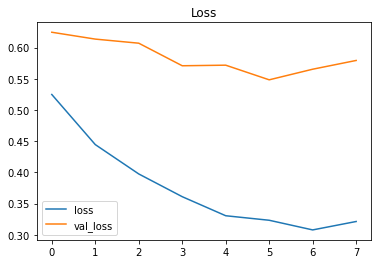

In [27]:
# let's visualizing loss overtime
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.show()

# Indexing

Indexing is where things get different from traditional classification models. Because the model learned to output an embedding that represent the example position in a metric space and not a classification, we need a way to find which known example(s) are the closest to determine the class of the incoming data (aka nearest neighboors classication).

To do so we need to create an index of known example from the 10 cloth classes. We do this by taking 100 examples from the train dataset which amount to 10 examples for each class and use the `index()` funtion of the model to build the index.

In [28]:
x_index, y_index = select_examples(x_train, y_train, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 10)
model.index_reset()
model.index(x_index, y_index)

# Querying

To "classify" our testing data, we need for each testing example to look for its *k* [nearest neighbors](https://scikit-learn.org/stable/modules/neighbors.html) in the index.

We query a single random example for each class from the test dataset using  `select_examples()` and then find their nearest neighboors using the `single_lookup()` function.

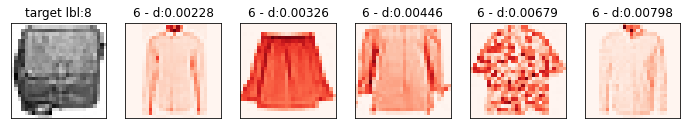

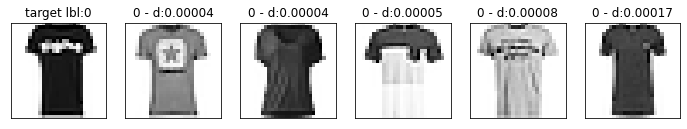

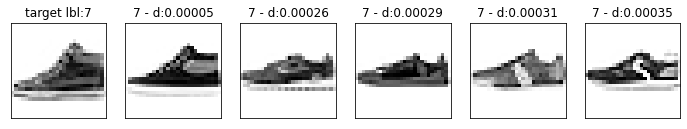

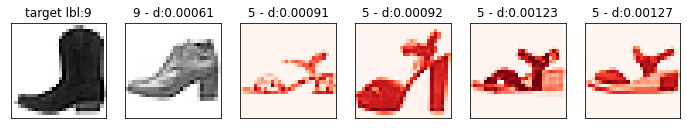

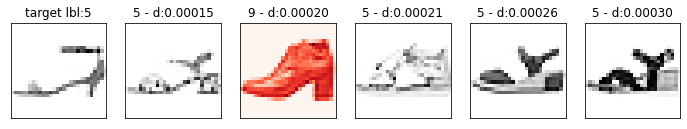

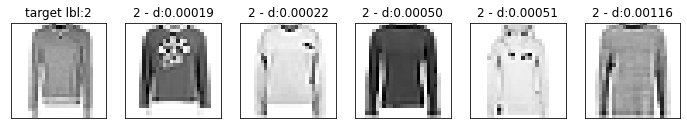

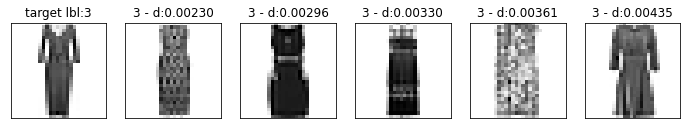

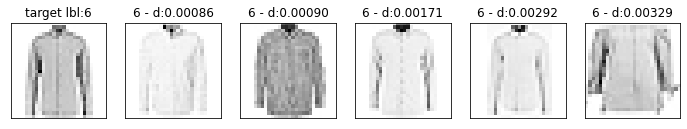

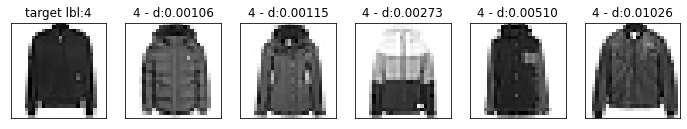

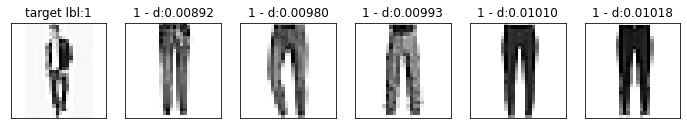

In [30]:
# re-run to test other examples
num_neighboors = 5
x_display, y_display = select_examples(x_test, y_test, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 1)

for idx in range(len(x_display)):
    # query closest matches
    neighboors = model.single_lookup(x_display[idx], k=num_neighboors)

    # view results close by
    viz_neigbors_imgs(x_display[idx], y_display[idx], neighboors, fig_size=(12, 2), cmap='Greys')



# matching

To be able to tell if an example match a given class, we first need to `calibrate()` the model to know what is the optimal cut point. We compute several cutpoints that correspond to different performance profile:
- **match** is the optimal cutpoint that represent the best balance between precision and recall
- **very likely** is the distance cutpoint that aim to ensure a 0.99 precision.

In [42]:
num_calibration_samples = 1000
calibration = model.calibrate(x_train[:num_calibration_samples], y_train[:num_calibration_samples], verbose=1)

num positive matches 1555/2000



cutpoint        distance
-----------  -----------
optimistic   0.00298083
likely       0.000190675
very_likely  3.0458e-05
optimal      0.0665641


Let's look how the performance metrics evolve as the distance between the sample increase. We clearly see the F1 optimial cutpoint where the precision and recall intersect.

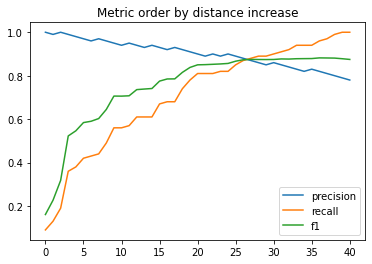

In [43]:
plt.plot(calibration['thresholds']['precision'], label='precision')
plt.plot(calibration['thresholds']['recall'], label='recall')
plt.plot(calibration['thresholds']['f1'], label='f1')
plt.legend()
plt.title("Metric order by distance increase")
plt.show()

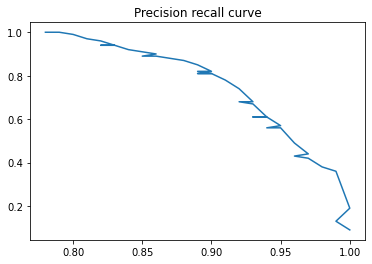

In [44]:
plt.plot(calibration['thresholds']['precision'], calibration['thresholds']['recall'])
plt.title("Precision recall curve")
plt.show()

# Evaluation
We evaluate our model ability to accurately match new examples using our calibrated threshold. 

In [48]:
metrics = model.evaluate_index(x_test, y_test)

metric       cutpoint <     all
---------  ------------  ------
recall          0.8284   1
accuracy        0.79418  0.7388
precision       0.79418  0.7388


# match


# Additional features

To be moved 

## Indexer stats

You can display the indexer performance summary using the `index_summary()` function.

In [51]:
model.index_summary()

[Index statistics]
----------------  ---
query_time          0
query               0
num_lookups       100
num_items         100
stat_buffer_size  100
----------------  ---

[Query performance]
------  -----------
min     0
max     0.000524282
avg     5.03087e-05
median  0
stddev  0.000150943
------  -----------


## Threshold viz

In [49]:
rows = []
thresholds = calibration['thresholds']
for idx in range(len(thresholds['distance'])):
    rows.append([thresholds['distance'][idx], thresholds['f1'][idx], thresholds['precision'][idx], thresholds['recall'][idx]])

print(tabulate(rows, headers=['distance', 'f1', 'precision', 'recall']))

   distance        f1    precision    recall
-----------  --------  -----------  --------
3.0458e-05   0.160852         1         0.09
4.27961e-05  0.226781         0.99      0.13
6.12736e-05  0.317838         1         0.19
0.000158191  0.522684         0.99      0.36
0.000190675  0.546296         0.98      0.38
0.000236392  0.584118         0.97      0.42
0.000246525  0.590179         0.96      0.43
0.000267863  0.602655         0.97      0.44
0.000353932  0.644501         0.96      0.49
0.000528574  0.706167         0.95      0.56
0.000530422  0.705882         0.94      0.56
0.000536919  0.707445         0.95      0.57
0.000666261  0.735856         0.94      0.61
0.000684381  0.738521         0.93      0.61
0.000692725  0.740971         0.94      0.61
0.000930548  0.775037         0.93      0.67
0.00100458   0.784894         0.92      0.68
0.00100803   0.785344         0.93      0.68
0.0014801    0.815264         0.92      0.74
0.00229347   0.837997         0.91      0.78
0.00291002